<a href="https://colab.research.google.com/github/osgeokr/GEE-PAM-Book/blob/main/Google_Earth_Engine_Maxent%EB%A5%BC_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EC%A2%85_%EB%B6%84%ED%8F%AC_%EB%AA%A8%EB%8D%B8%EB%A7%81_Pitta_nympha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Google Earth Engine: Maxent를 이용한 종 분포 모델링

안녕하세요? 이번 글은 Google Earth Engine의 **Maxent** 소프트웨어 구현 기능을 간략히 소개해 보겠습니다. [Maxent](https://biodiversityinformatics.amnh.org/open_source/maxent/)는 알려진 출현 위치와 대규모 '배경' 위치의 환경 데이터를 사용하여 종 분포 확률을 모델링하는 데 사용됩니다. 자세한 정보와 인용은 다음을 참조하시면 되겠습니다:
  > Phillips, et. al., 2004 A maximum entropy approach to species distribution modeling, Proceedings of the Twenty-First International Conference on Machine Learning

Google Earth Engine에서 [ee.Classifier.amnhMaxent](https://developers.google.com/earth-engine/apidocs/ee-classifier-amnhmaxent) 메소드는 Maximum Entropy(최대 엔트로피) 분류기를 생성합니다. 여기서 AMNH는 미국 자연사박물관(American Museum of Natural History)의 약어입니다. Maxent의 아이디어는 미국 자연사박물관 내 생물다양성보전센터(Center for Biodiversity and Conservation)에서 AMNH와 AT&T-Research 간의 공공-민간 파트너십을 통해 처음 구상되었습니다.

출력은 `probability`라는 이름의 단일 밴드로 모델링된 확률을 포함하며, `writeClampGrid` 인수가 참일 경우 `clamp`라는 추가 밴드가 포함됩니다.

In [20]:
import ee
import geemap
import geemap.colormaps as cm
import requests
import pandas as pd, geopandas as gpd
import matplotlib.pyplot as plt

from google.colab import files

Google Earth Engine에서 종 분포 확률을 모델링하는 방법은 제가 집필한 [Earth Engine Community Tutorial - Species Distribution Modeling](https://developers.google.com/earth-engine/tutorials/community/species-distribution-modeling)에 상세히 소개되어 있습니다. 따라서 이 글은 Maxent 구현 기능 예제를 중심으로 정리하겠습니다. 먼저 Earth Engine을 인증/초기화 합니다.

In [10]:
# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-foss4g')

In [11]:
def get_gbif_species_data(species_name, country_code):
    """
    Retrieves observational data for a specific species using the GBIF API and returns it as a pandas DataFrame.

    Parameters:
    species_name (str): The scientific name of the species to query.
    country_code (str): The country code of the where the observation data will be queried.

    Returns:
    pd.DataFrame: A pandas DataFrame containing the observational data.
    """
    base_url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "scientificName": species_name,
        "country": country_code,
        "hasCoordinate": "true",
        "basisOfRecord": "HUMAN_OBSERVATION",
        "limit": 10000,
    }

    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raises an exception for a response error.
        data = response.json()
        occurrences = data.get("results", [])

        if occurrences:  # If data is present
            df = pd.json_normalize(occurrences)
            return df
        else:
            print("No data found for the given species and country code.")
            return pd.DataFrame()  # Returns an empty DataFrame
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        return pd.DataFrame()  # Returns an empty DataFrame in case of an exception

In [13]:
# Retrieve Fairy Pitta data
df = get_gbif_species_data("Pitta nympha", "KR")

# Save DataFrame to CSV and read back in.
df.to_csv("pitta_nympha_data.csv", index=False)
df = pd.read_csv("pitta_nympha_data.csv")

df.head(1)  # Display the first row of the DataFrame

,key,datasetKey,publishingOrgKey,installationKey,hostingOrganizationKey,publishingCountry,protocol,lastCrawled,lastParsed,crawlId,...,nomenclaturalCode,fieldNotes,behavior,verbatimElevation,higherClassification,extensions.http://rs.tdwg.org/ac/terms/Multimedia,distanceFromCentroidInMeters,associatedTaxa,lifeStage,occurrenceRemarks
0,4875314160,50c9509d-22c7-4a22-a47d-8c48425ef4a7,28eb1a3f-1c15-4a95-931a-4af90ecb574d,997448a8-f762-11e1-a439-00145eb45e9a,28eb1a3f-1c15-4a95-931a-4af90ecb574d,US,DWC_ARCHIVE,2024-06-17T19:17:08.194+00:00,2024-06-19T01:37:19.064+00:00,466,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


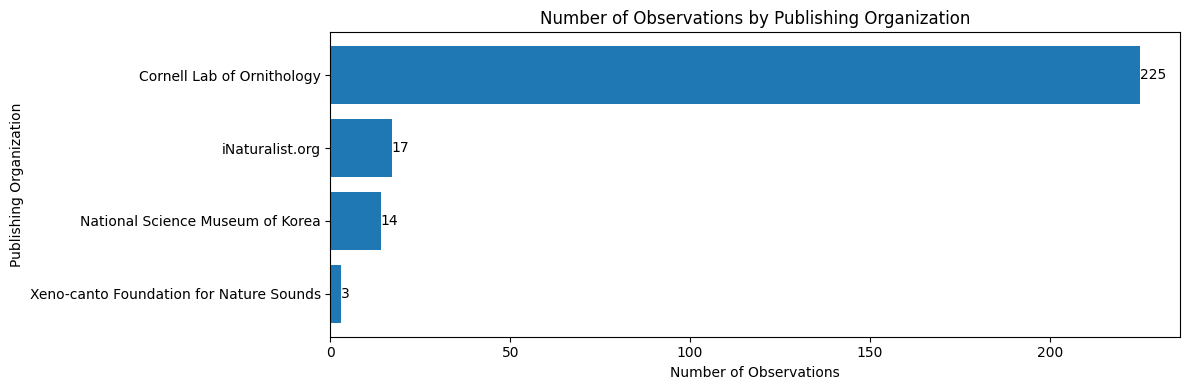

In [19]:
# Step 1: Group by 'publishingOrgKey' and count the number of occurrences
org_counts = df['publishingOrgKey'].value_counts()

# Step 2: Function to get organization details
def get_organization_name(publishing_org_key):
    org_url = f"https://api.gbif.org/v1/organization/{publishing_org_key}"
    org_response = requests.get(org_url)
    if org_response.status_code == 200:
        org_data = org_response.json()
        return org_data.get('title', 'Unknown')
    else:
        return 'Unknown'

# Step 3: Get organization names for each publishingOrgKey
org_names = [get_organization_name(key) for key in org_counts.index]

# Step 4: Create a DataFrame for plotting and sort by count in descending order
plot_data = pd.DataFrame({
    'Organization': org_names,
    'Count': org_counts.values
}).sort_values(by='Count', ascending=True)

# Step 5: Plot the data as a horizontal bar chart
plt.figure(figsize=(12, 4))
bars = plt.barh(plot_data['Organization'], plot_data['Count'])
plt.ylabel('Publishing Organization')
plt.xlabel('Number of Observations')
plt.title('Number of Observations by Publishing Organization')
plt.tight_layout()

# Step 6: Add labels to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}',
             va='center', ha='left')

# Show the plot
plt.show()

In [21]:
# publishingOrgKey를 실제 이름으로 변환
df['publishingOrgName'] = df['publishingOrgKey'].apply(get_organization_name)

# Cornell Lab of Ornithology 데이터만 선택
cornell_df = df[df['publishingOrgName'] == 'Cornell Lab of Ornithology']

# 선택된 데이터를 CSV 파일로 저장
cornell_df.to_csv('cornell_lab_of_ornithology_data.csv', index=False)

# 파일을 로컬 컴퓨터로 다운로드
files.download('cornell_lab_of_ornithology_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

일단, 출현/부재 훈련 데이터를 임의 생성합니다. 아래 코드는 ee.Classifier.amnhMaxent 메소드의 예제 코드를 그대로 차용했습니다.

In [ ]:
# 출현/부재 훈련 데이터 생성
training_data = ee.FeatureCollection([
    # 종 출현 지점
    ee.Feature(ee.Geometry.Point([-122.39567, 38.02740]), {'presence': 1}),
    ee.Feature(ee.Geometry.Point([-122.68560, 37.83690]), {'presence': 1}),
    # 종 부재 지점
    ee.Feature(ee.Geometry.Point([-122.59755, 37.92402]), {'presence': 0}),
    ee.Feature(ee.Geometry.Point([-122.47137, 37.99291]), {'presence': 0}),
    ee.Feature(ee.Geometry.Point([-122.52905, 37.85642]), {'presence': 0}),
    ee.Feature(ee.Geometry.Point([-122.03010, 37.66660]), {'presence': 0})
])

환경 조건으로 Landsat 8호 이미지를 가져와 반사율 밴드를 선택해 보겠습니다. Earth Engine Snippet에서 각각의 약어는 다음을 지칭합니다.
- `C02`: Collection 2
- `T1`: Tier 1
- `L2`: Level 2
- `044034`: `044`는 경로 번호(Path), `034`는 열 번호(Row)
- `20200606`: 이미지 촬영 날짜

In [ ]:
# Landsat 8호 이미지를 가져와 반사율 밴드 선택
image = (ee.Image('LANDSAT/LC08/C02/T1_L2/LC08_044034_20200606')
         .select(['SR_B[1-7]'])
         .multiply(0.0000275).add(-0.2))  # 축척 계수 적용

Landsat 8호 이미지 밴드 객체 내에서 특정 종의 출현/부재 위치에 해당하는 데이터 샘플을 추출합니다. 여기서 `scale` 매개변수는 샘플링의 공간 해상도를 의미합니다.

In [ ]:
# 종 출현/부재 위치에서 이미지 샘플링
training = image.sampleRegions(**{
    'collection': training_data,
    'scale': 30
})

이제 Google Earth Engine의 Maxent 분류기를 통해, 종 분포 모델을 정의하고 훈련하는 과정을 실행합니다. 훈련 데이터 내에서 예측하고자 하는 대상 속성(`presence`)을 지정하고, 이미지의 모든 분광 정보를 활용하여 종이 존재할 가능성이 있는 지역을 예측합니다.

In [ ]:
# Maxent 분류기 정의 및 훈련
classifier = ee.Classifier.amnhMaxent().train(**{
    'features': training,
    'classProperty': 'presence',
    'inputProperties': image.bandNames()
})

훈련된 Maxent 분류기를 이용하여 위성 이미지로 종의 분포를 예측합니다.

In [ ]:
# Maxent 분류기를 사용하여 이미지 분류
image_classified = image.classify(classifier)

원본 이미지, 종 분포 확률, 훈련 데이터 레이어를 시각화해 봅니다. 종 출현 위치는 파란색, 종 부재 위치는 빨간색으로 표시하였습니다.

In [ ]:
# 지도 생성
m = geemap.Map(layout={'height':'400px', 'width':'800px'})

# 원본 이미지 레이어
m.addLayer(
    image.select(['SR_B4', 'SR_B3', 'SR_B2']),
    {'min': 0, 'max': 0.3}, 'Image'
)

# 분류된 확률 레이어
m.addLayer(
    image_classified.select('probability'),
     {'min': 0, 'max': 1, 'palette': cm.palettes.viridis_r}, 'Probability'
)

# 훈련 데이터 레이어
m.addLayer(
    training_data.filter(ee.Filter.eq('presence', 0)), {'color': 'red'},
    '종 부재'
)
m.addLayer(
    training_data.filter(ee.Filter.eq('presence', 1)), {'color': 'blue'},
    '종 출현'
)

# 지도 표시
m.centerObject(training_data, 10)
m

Map(center=[37.88422765713263, -122.45138012292709], controls=(WidgetControl(options=['position', 'transparent…